In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyIsoPEP.IsotonicPEP import IsotonicPEP

### prepare a concatenated target-decoy peptide list

df_target = pd.read_csv("output/run1/splinePEP/0/peptide.target.txt", sep="\t")
df_decoy = pd.read_csv("output/run1/splinePEP/0/peptide.decoy.txt", sep="\t")
df_target["type"] = "0"
df_decoy["type"] = "1"
df_cat = pd.concat([df_target, df_decoy], ignore_index=True)
df_cat.to_csv("example/peptide.cat.txt", sep='\t', index=False)

pep_processor = IsotonicPEP()
df_cat = pd.read_csv("example/peptide.cat.txt", sep='\t', dtype={"type": str})
columns_to_drop = ["PSMId", "filename", "peptide", "proteinIds"]
df_cat = df_cat.drop(columns=columns_to_drop)
df_cat = df_cat.rename(columns={"posterior_error_prob": "spline"})
df_target = df_cat[df_cat["type"] == "0"]
df_target = df_target.copy()
df_target["obs2pep_cat"], df_target["obs2q_cat"] = pep_processor.pep_regression(obs=df_cat[["score", "type"]].values, method="obs2pep", target_label="0", decoy_label="1")

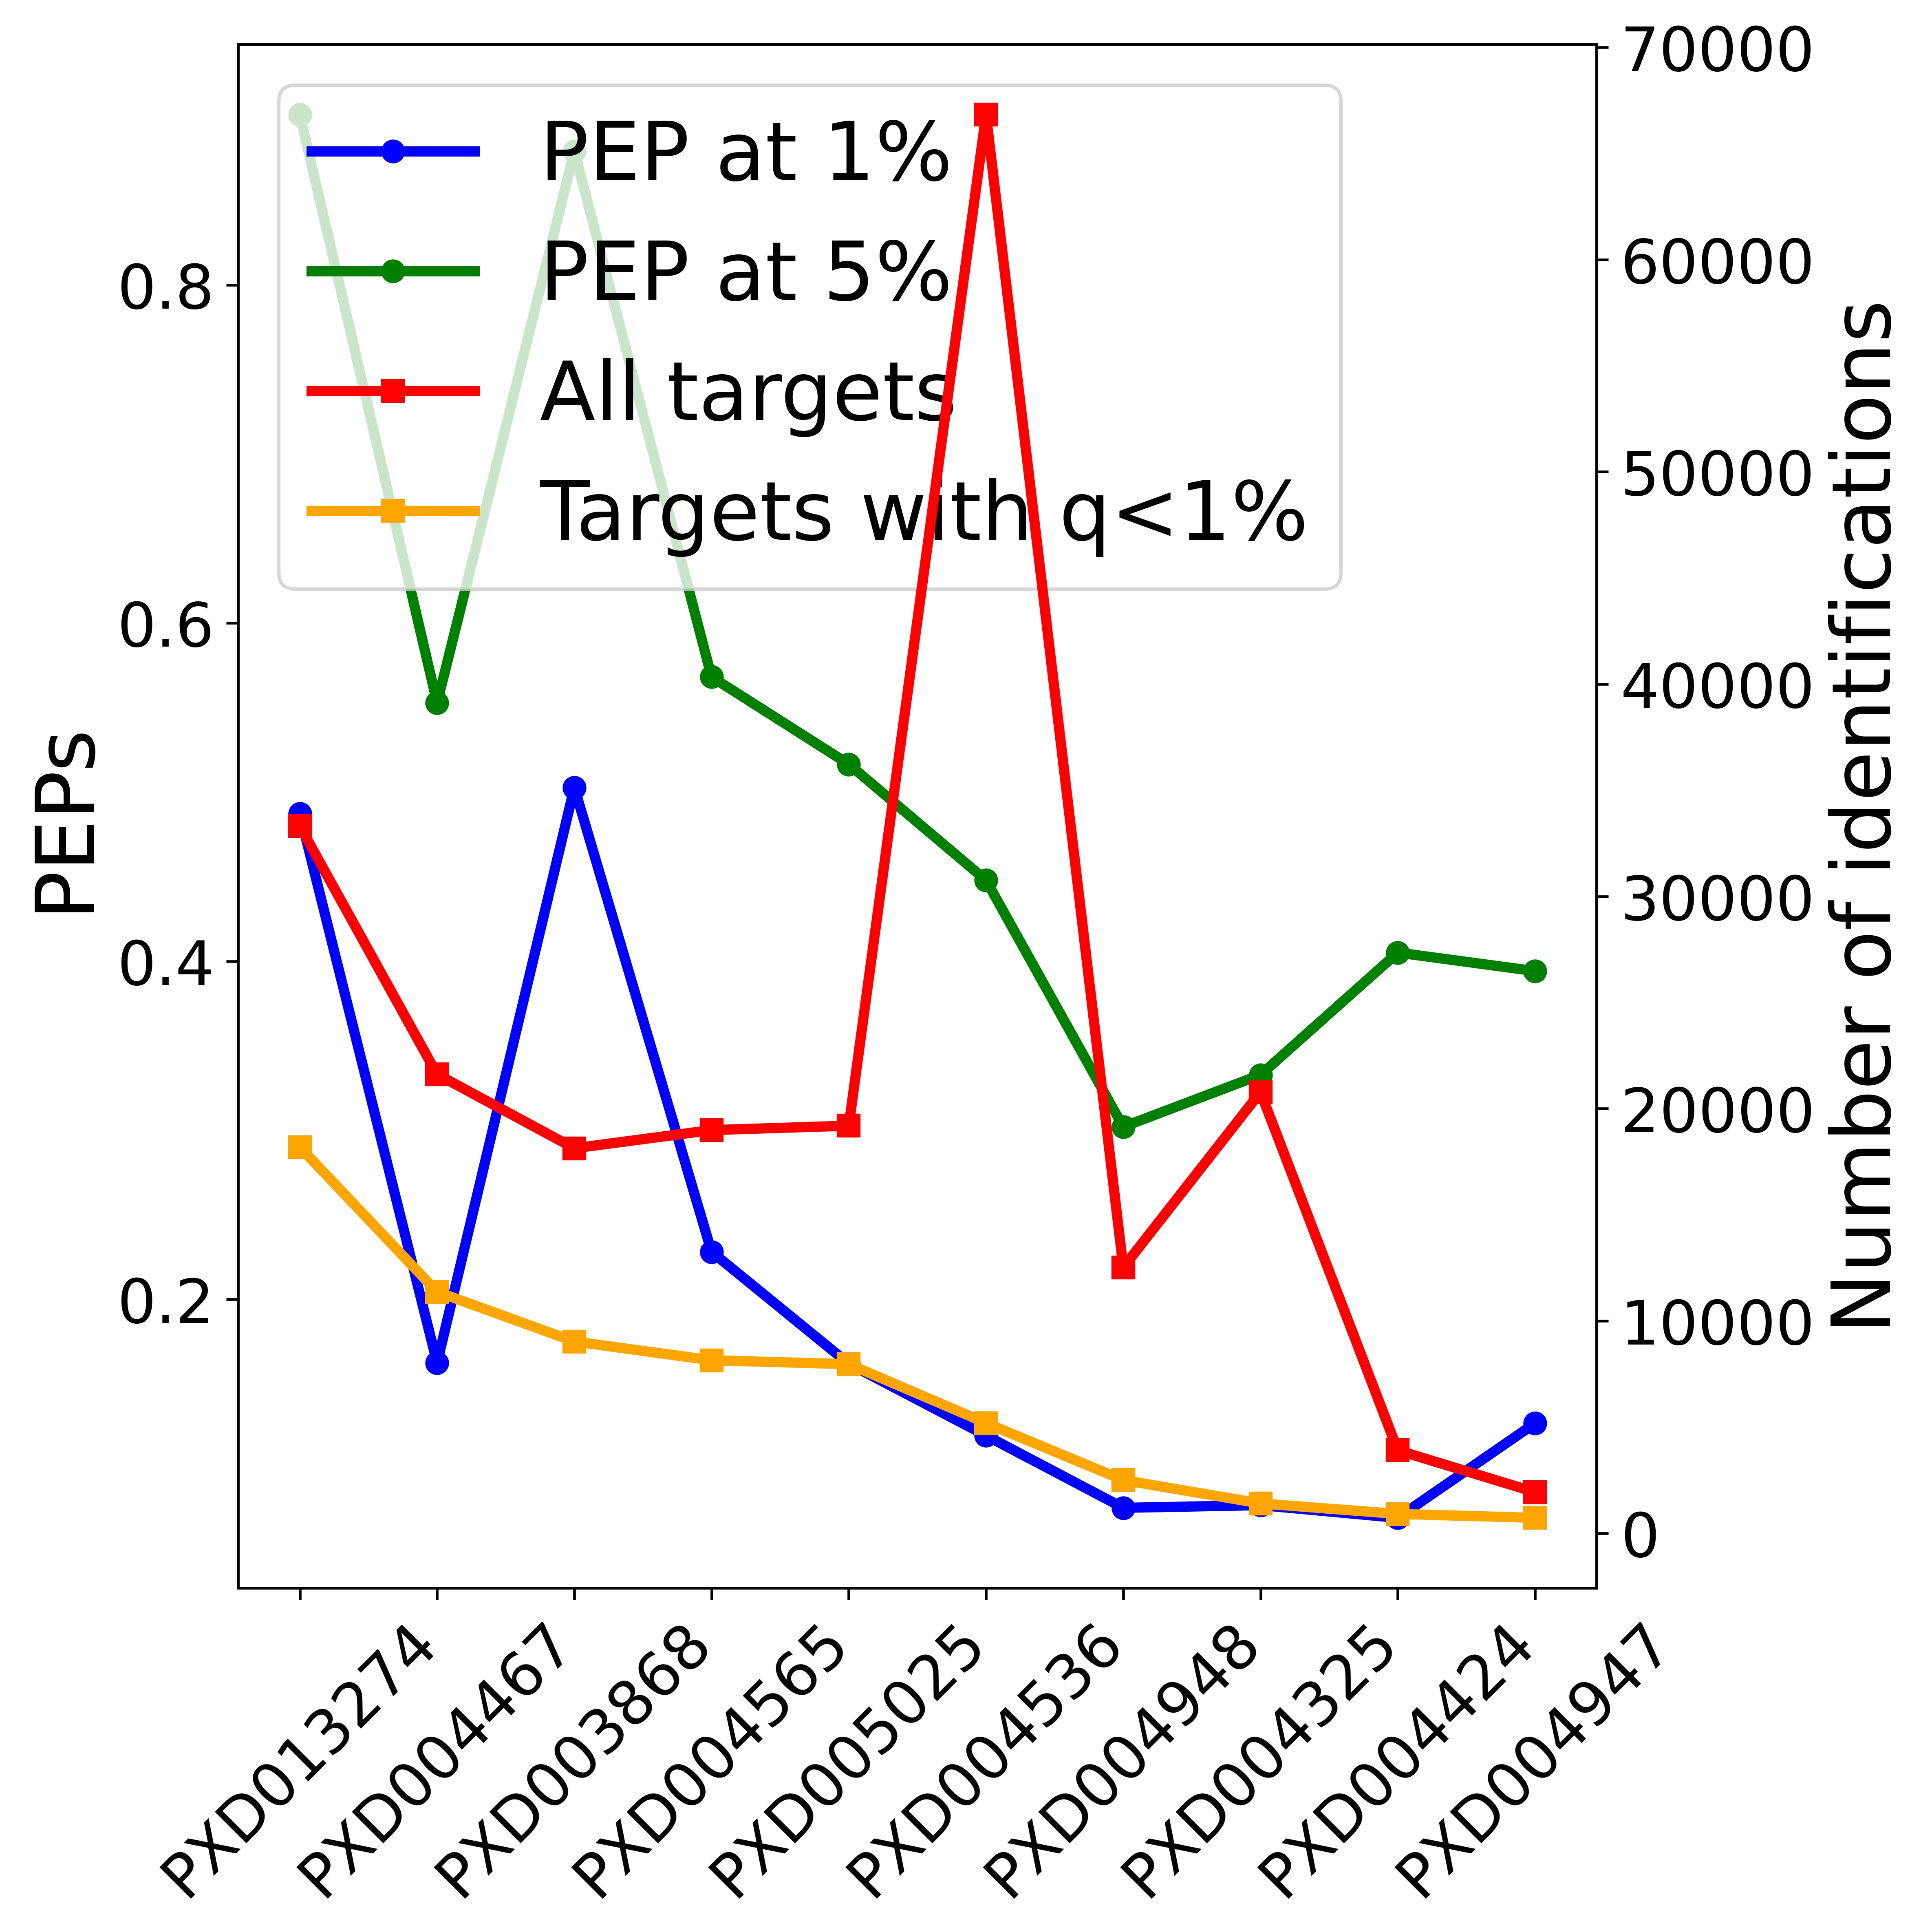

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapping of file paths to dataset labels.
file_mapping = {
    
    "output/run1/splinePEP/0/peptide.target.txt": "PXD013274",
    "/home/yuqizh/quickt/PXD004467/percolator.target.peptides.txt": "PXD004467",
    "/home/yuqizh/quickt/PXD003868/percolator.target.peptides.txt": "PXD003868",
    "/home/yuqizh/quickt/PXD004565/percolator.target.peptides.txt": "PXD004565",
    "/home/yuqizh/quickt/PXD005025/percolator.target.peptides.txt": "PXD005025",
    "/home/yuqizh/quickt/PXD004536/percolator.target.peptides.txt": "PXD004536",
    "/home/yuqizh/quickt/PXD004948/percolator.target.peptides.txt": "PXD004948",
    "/home/yuqizh/quickt/PXD004325/percolator.target.peptides.txt": "PXD004325",
    "/home/yuqizh/quickt/PXD004424/percolator.target.peptides.txt": "PXD004424",
    "/home/yuqizh/quickt/PXD004947/percolator.target.peptides.txt": "PXD004947"
    
}

# Dummy mappings for number of identifications. 
# Replace these values with your actual counts.
ident_all = {
    "PXD013274": 33311,
    "PXD004325": 20783,
    "PXD004947": 1936,
    "PXD005025": 19198,
    "PXD004565": 18992,
    "PXD004536": 66830,
    "PXD003868": 18136,
    "PXD004467": 21618,
    "PXD004948": 12523,
    "PXD004424": 3906
}
ident_under_1 = {
    "PXD013274": 18187,
    "PXD004325": 1401,
    "PXD004947": 724,
    "PXD005025": 7962,
    "PXD004565": 8148,
    "PXD004536": 5190,
    "PXD003868": 9030,
    "PXD004467": 11373,
    "PXD004948": 2503,
    "PXD004424": 907
}

# Initialize lists to hold the dataset labels and the PEP values at 1% and 5%
dataset_labels = []
pep_at_1 = []
pep_at_5 = []

# Set the target q-value thresholds (in percentage)
target_q1 = 1   # corresponds to 1%
target_q5 = 5   # corresponds to 5%

# Create your isotonic PEP processor (assuming IsotonicPEP is defined/imported)
pep_processor = IsotonicPEP()

# Loop over each dataset, process the data, and extract the PEP values at 1% and 5%.
for file_path, label in file_mapping.items():
    df_target = pd.read_csv(file_path, sep="\t")
    df_target["q2pep"], df_target["q_q2pep"] = pep_processor.pep_regression(
        q_values=df_target["q-value"].values, 
        method="q2pep", 
        pava_method="ip",
        ip_method="pchip"
    )
    # Filter to a q-value cutoff (here, we use 0.25 as in your code)
    df_sub = df_target[df_target["q-value"] <= 0.25]
    # Multiply q-values by 100 to convert to percentage scale
    q_values = df_sub["q-value"] * 100

    # Find the index where q-value is closest to target 1% and 5%
    idx1 = (q_values - target_q1).abs().idxmin()
    idx5 = (q_values - target_q5).abs().idxmin()
    # Extract the corresponding PEP values
    pep1_value = df_sub.loc[idx1, "q2pep"]
    pep5_value = df_sub.loc[idx5, "q2pep"]

    # Save the values along with the dataset label
    dataset_labels.append(label)
    pep_at_1.append(pep1_value)
    pep_at_5.append(pep5_value)

# Create a new figure with twin y-axes.
fig, ax1 = plt.subplots(figsize=(8, 8), dpi=600)

# Use x positions corresponding to each dataset (0,1,2,...)
x_positions = range(len(dataset_labels))

# Plot the PEP values on the left y-axis.
ax1.plot(x_positions, pep_at_1, marker='o', label="PEP at 1%", linewidth=3, color='blue')
ax1.plot(x_positions, pep_at_5, marker='o', label="PEP at 5%", linewidth=3, color='green')
ax1.set_ylabel("PEPs", fontsize=24)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(dataset_labels, fontsize=18, rotation=45)
ax1.tick_params(axis='y', labelsize=18)

# Create a second y-axis for the identification counts.
ax2 = ax1.twinx()
# Get the identification counts for each dataset from the provided mappings.
ident_all_list = [ident_all[label] for label in dataset_labels]
ident_under_1_list = [ident_under_1[label] for label in dataset_labels]

ax2.plot(x_positions, ident_all_list, marker='s', label="All targets", linewidth=3, color='red')
ax2.plot(x_positions, ident_under_1_list, marker='s', label="Targets with q<1%", linewidth=3, color='orange')
ax2.set_ylabel("Number of identifications", fontsize=24)
ax2.tick_params(axis='y', labelsize=18)

# Combine the legends from both y-axes.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=24)

plt.xlabel("Dataset", fontsize=24)
plt.tight_layout()
plt.savefig("figs/pep_vs_idents.png", bbox_inches="tight")
plt.show()


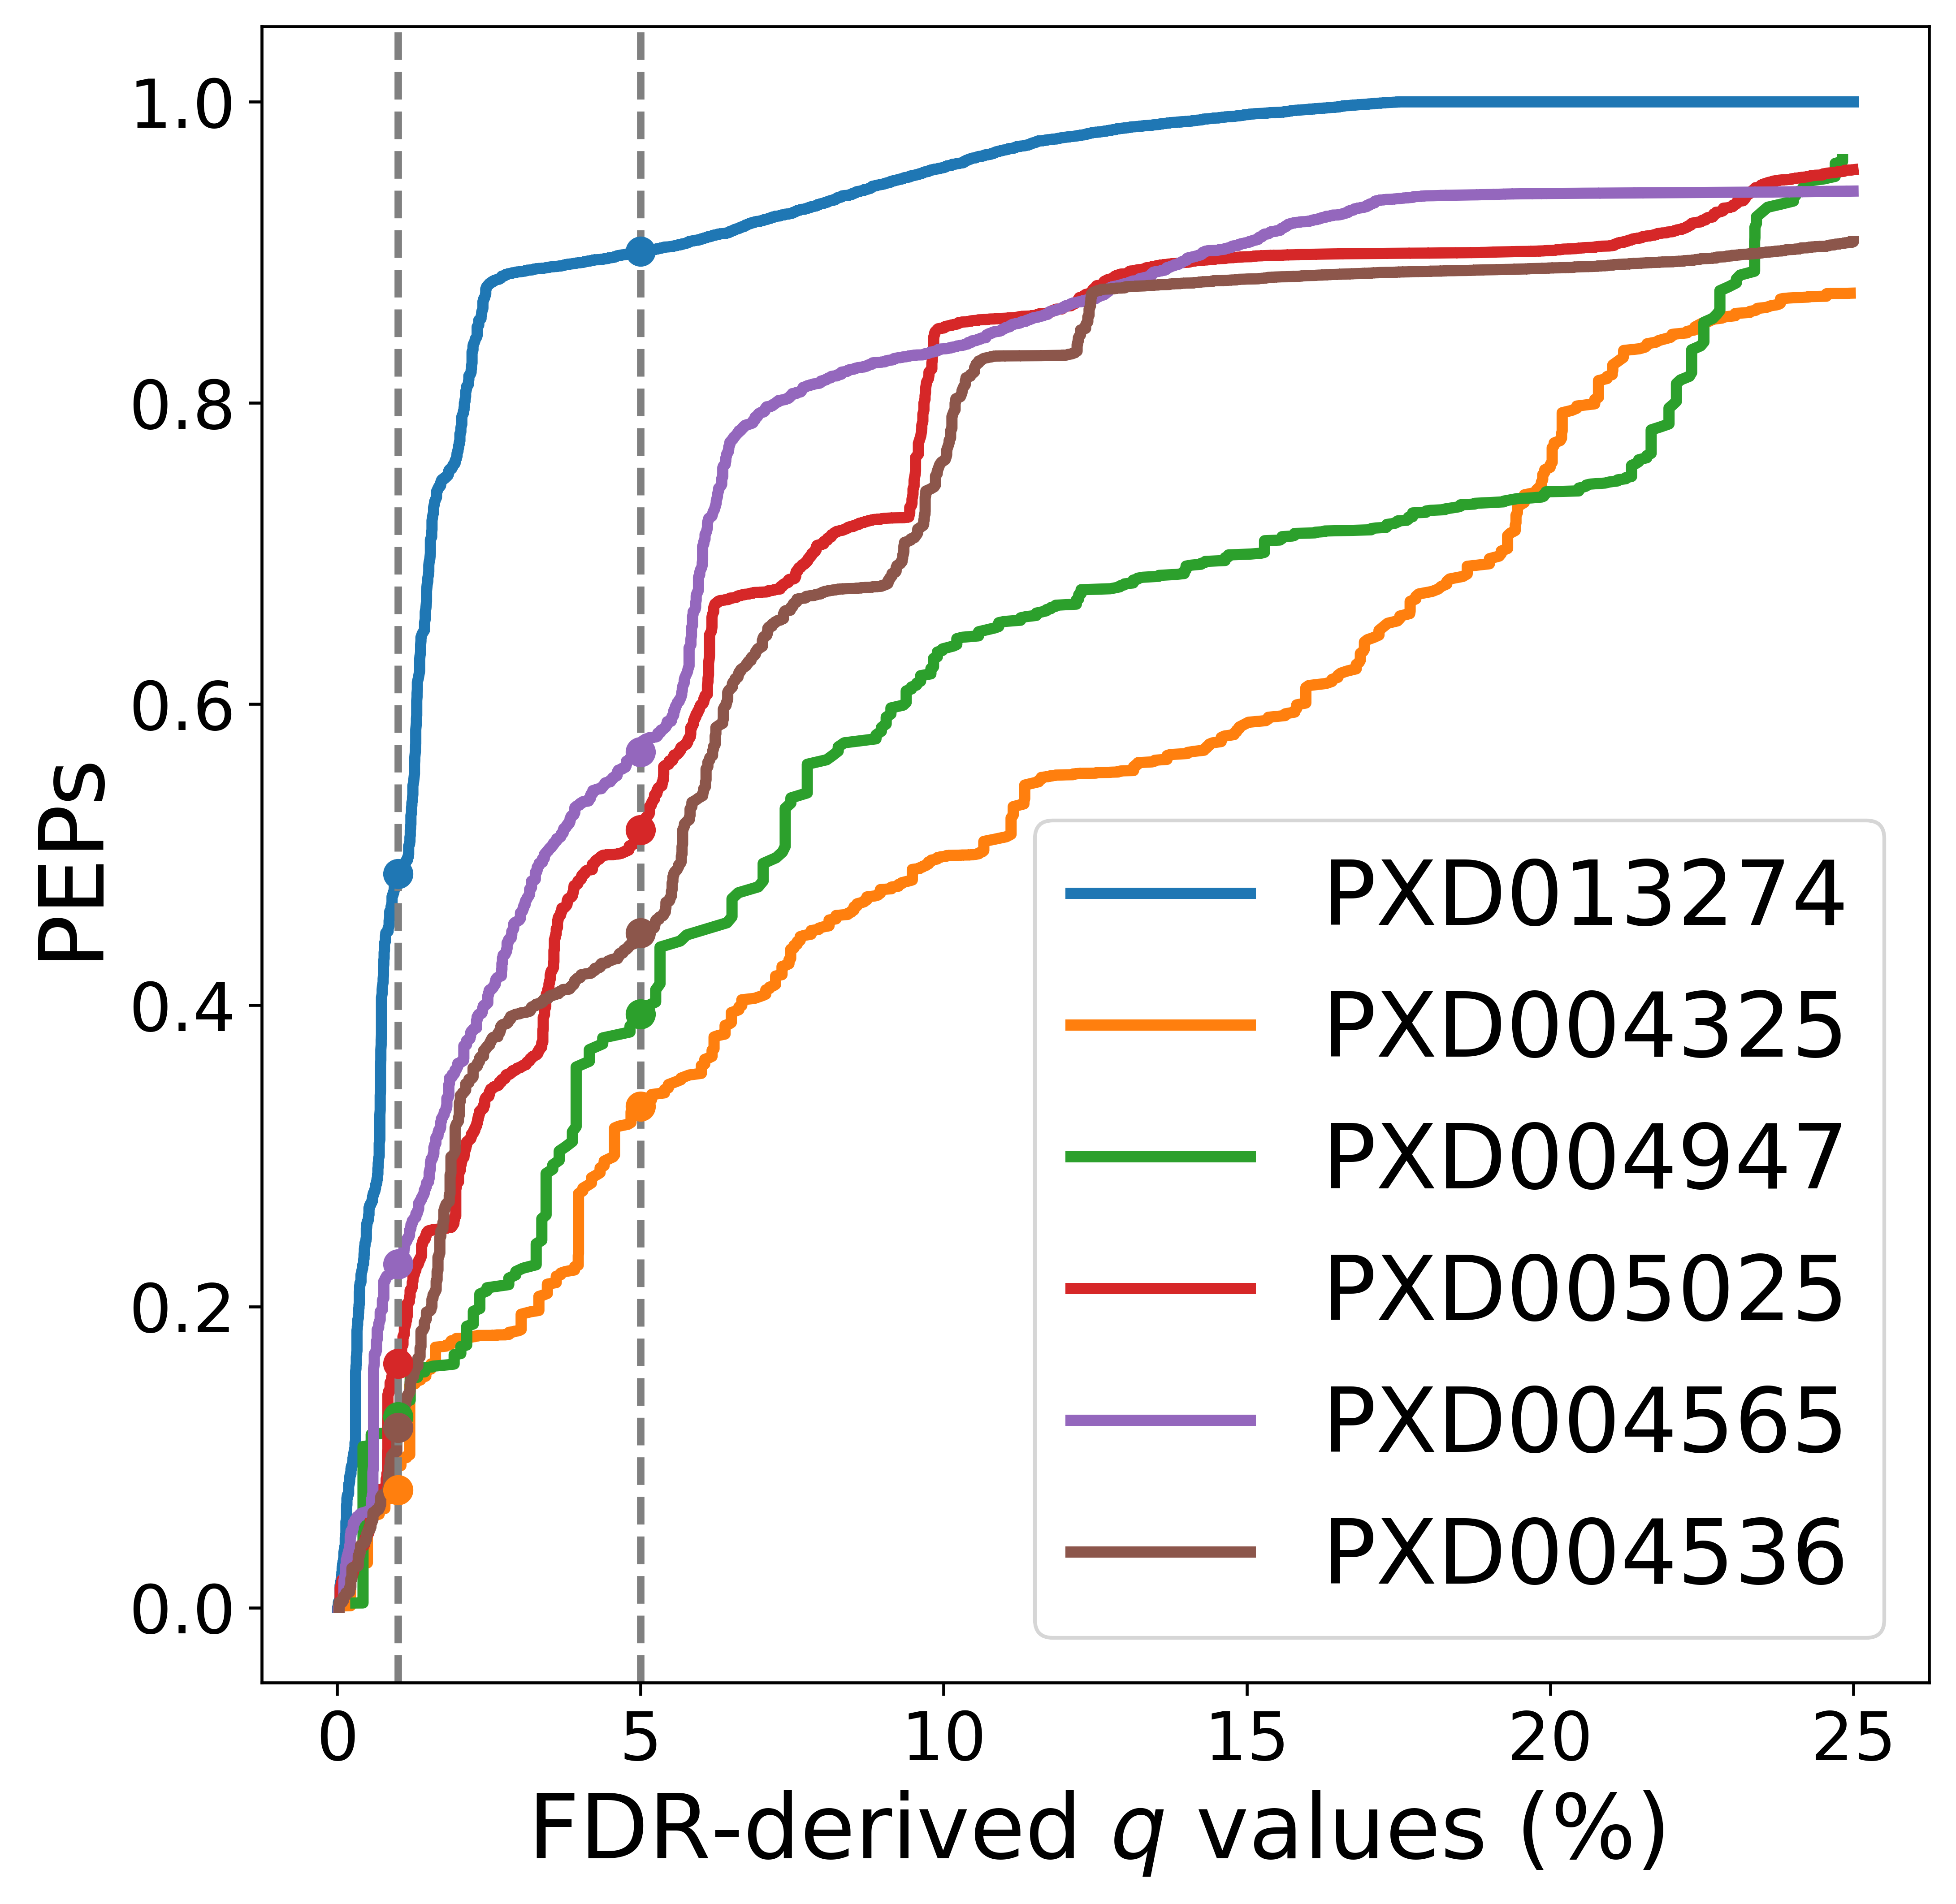

In [72]:
file_mapping = {
    "output/run1/splinePEP/0/peptide.target.txt": "PXD013274",
    "/home/yuqizh/quickt/PXD004325/percolator.target.peptides.txt": "PXD004325",
    "/home/yuqizh/quickt/PXD004947/percolator.target.peptides.txt": "PXD004947",
    "/home/yuqizh/quickt/PXD005025/percolator.target.peptides.txt": "PXD005025",
    "/home/yuqizh/quickt/PXD004565/percolator.target.peptides.txt": "PXD004565",
    "/home/yuqizh/quickt/PXD004536/percolator.target.peptides.txt": "PXD004536"
}
pep_processor = IsotonicPEP()

plt.figure(figsize=(8, 8), dpi=600)
vertical_x = 1
vertical_x5 = 5
for file_path, label in file_mapping.items():
    df_target = pd.read_csv(file_path, sep="\t")
    df_target["q2pep"], df_target["q_q2pep"] = pep_processor.pep_regression(
        q_values=df_target["q-value"].values, 
        method="q2pep", 
        pava_method="ip"
    )
    df_sub = df_target[df_target["q-value"] <= 0.25]
    q_values = df_sub["q-value"] * 100
    
    line, = plt.plot(q_values, df_sub["q2pep"], label=label, linewidth=3)
    curve_color = line.get_color()
    idx1 = (q_values - vertical_x).abs().idxmin()
    pep_val1 = df_sub.loc[idx1, "q2pep"]
    idx5 = (q_values - vertical_x5).abs().idxmin()
    pep_val5 = df_sub.loc[idx5, "q2pep"]
    plt.scatter([vertical_x], [pep_val1], color=curve_color, s=50, zorder=3)
    plt.scatter([vertical_x5], [pep_val5], color=curve_color, s=50, zorder=3)
plt.axvline(x=vertical_x, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=vertical_x5, color='grey', linestyle='--', linewidth=2)

plt.xlabel("FDR-derived $q$ values (%)", fontsize=24)
plt.ylabel("PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.savefig(f"figs/pep_vs_qvalue_ir.png",bbox_inches="tight")
plt.show()

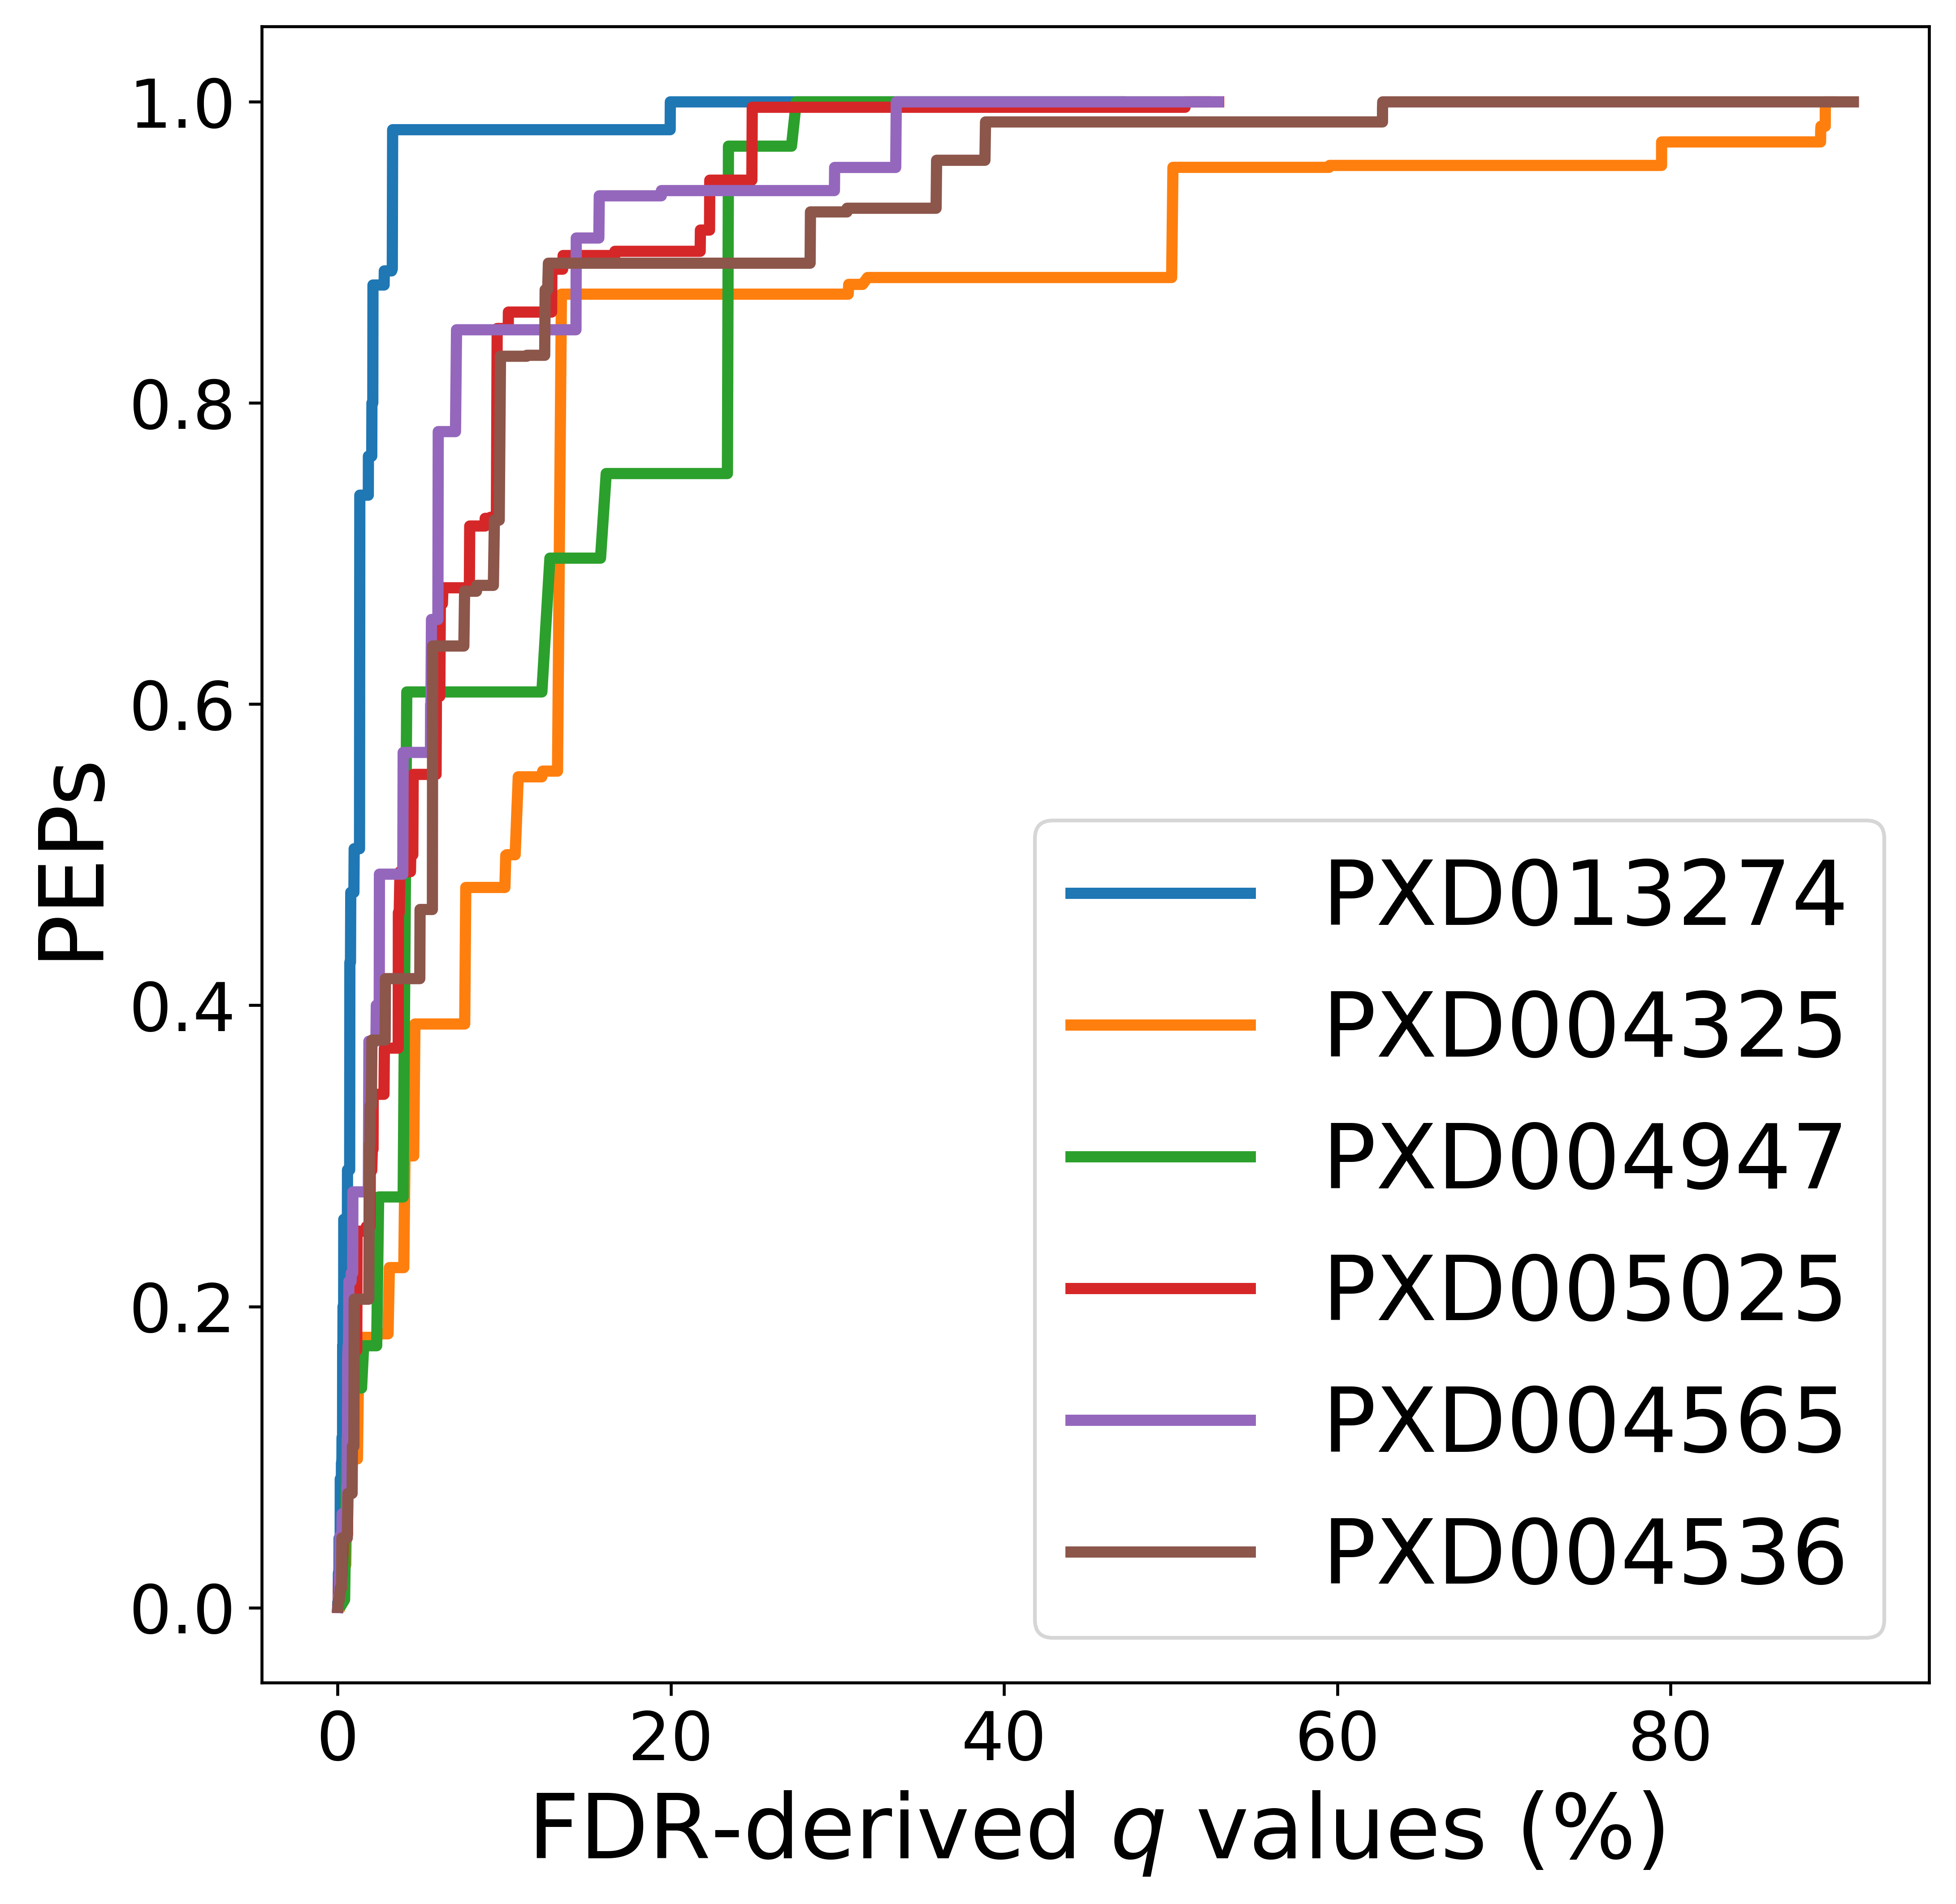

In [78]:
file_mapping = {
    "output/run1/splinePEP/0/peptide.target.txt": "PXD013274",
    "/home/yuqizh/quickt/PXD004325/percolator.target.peptides.txt": "PXD004325",
    "/home/yuqizh/quickt/PXD004947/percolator.target.peptides.txt": "PXD004947",
    "/home/yuqizh/quickt/PXD005025/percolator.target.peptides.txt": "PXD005025",
    "/home/yuqizh/quickt/PXD004565/percolator.target.peptides.txt": "PXD004565",
    "/home/yuqizh/quickt/PXD004536/percolator.target.peptides.txt": "PXD004536"
}
pep_processor = IsotonicPEP()

plt.figure(figsize=(8, 8), dpi=600)
vertical_x = 1
vertical_x5 = 5
for file_path, label in file_mapping.items():
    df_target = pd.read_csv(file_path, sep="\t")
    df_target["q2pep"], df_target["q_q2pep"] = pep_processor.pep_regression(
        q_values=df_target["q-value"].values, 
        method="q2pep", 
        pava_method="basic"
    )
    df_sub = df_target[df_target["q-value"] <= 1]
    q_values = df_sub["q-value"] * 100
    
    line, = plt.plot(q_values, df_sub["q2pep"], label=label, linewidth=3)
    curve_color = line.get_color()

plt.xlabel("FDR-derived $q$ values (%)", fontsize=24)
plt.ylabel("PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyIsoPEP.IsotonicPEP import IsotonicPEP

In [2]:
df_target = pd.read_csv("output/run1/splinePEP/0/peptide.target.txt", sep="\t")
df_decoy = pd.read_csv("output/run1/splinePEP/0/peptide.decoy.txt", sep="\t")
# df_target = pd.read_csv("/home/yuqizh/quickt/PXD004325/percolator.target.peptides.txt", sep="\t")
# df_decoy = pd.read_csv("/home/yuqizh/quickt/PXD004325/percolator.decoy.peptides.txt", sep="\t")
columns_to_drop = ["PSMId", "filename", "peptide", "proteinIds"]
df_target = df_target.drop(columns=columns_to_drop)
df_decoy = df_decoy.drop(columns=columns_to_drop)
df_target = df_target.rename(columns={"posterior_error_prob": "spline"})
df_decoy = df_decoy.rename(columns={"posterior_error_prob": "spline"})

In [3]:
pep_processor = IsotonicPEP()
df_target["obs2pep"], df_target["q_obs2pep"] = pep_processor.pep_regression(target=df_target["score"].values, decoy=df_decoy["score"].values, method="obs2pep")
df_target["q2pep"], df_target["q_q2pep"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="basic")
df_target["q2pep_pchip"], df_target["q_q2pep_pchip"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="ip", ip_method="pchip")
df_target["q2pep_ispline"], df_target["q_q2pep_ispline"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="ip", ip_method="ispline")
# df_target["q2pep_smooth"], df_target["q_q2pep_smooth"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="basic", smooth=True)
# df_target["q2pep_ip_smooth"], df_target["q_q2pep_ip_smooth"] = pep_processor.pep_regression(q_values=df_target["q-value"].values, method="q2pep", pava_method="ip", smooth=True)
df = df_target

In [4]:
def estimate_q(df, pep_col):
    df = df.copy()
    df['orig_order'] = range(len(df))
    df_sorted = df.sort_values(by="q-value", kind="mergesort")
    df_sorted[f"q_{pep_col}"] = df_sorted[pep_col].cumsum() / np.arange(1, len(df_sorted) + 1)
    df_sorted = df_sorted.sort_values(by='orig_order').drop(columns='orig_order')
    return df_sorted

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

In [5]:
label_mapping = {
    'spline': {'label': 'Spline', 'linestyle': '-'},
    'obs2pep': {'label': 'from TDC', 'linestyle': '-'},
    'q2pep': {'label': '$q$: IR', 'linestyle': '-'},
    'q2pep_pchip': {'label': "$q$: IR-PCHIP", 'linestyle': '-'},
    'q2pep_ispline': {'label': "$q$: IR-ISpline", 'linestyle': '-'},
    # 'q2pep_ip': {'label': 'PAVA-linear-ip', 'linestyle': '-'},
    'q2pep_smooth': {'label': 'smooth PAVA', 'linestyle': '-'},
    'q2pep_ip_smooth': {'label': 'smooth ip-PAVA', 'linestyle': '-'}
}
methods = ["spline", "obs2pep", "q2pep", "q2pep_pchip", "q2pep_ispline"]

In [6]:
df = estimate_q(df, "spline")
q_values = df["q-value"].values
for m in methods:
    # df = estimate_q(df, m)
    max_diff = cal_max_rel_diff(df["q-value"].values, df[f"q_{m}"].values)
    print(f"{label_mapping[m]['label']}: {max_diff:.0f}%")

Spline: 207%
from TDC: 373%
$q$: IR: 175%
$q$: IR-PCHIP: 65%
$q$: IR-ISpline: 65%


<Figure size 4800x4800 with 0 Axes>

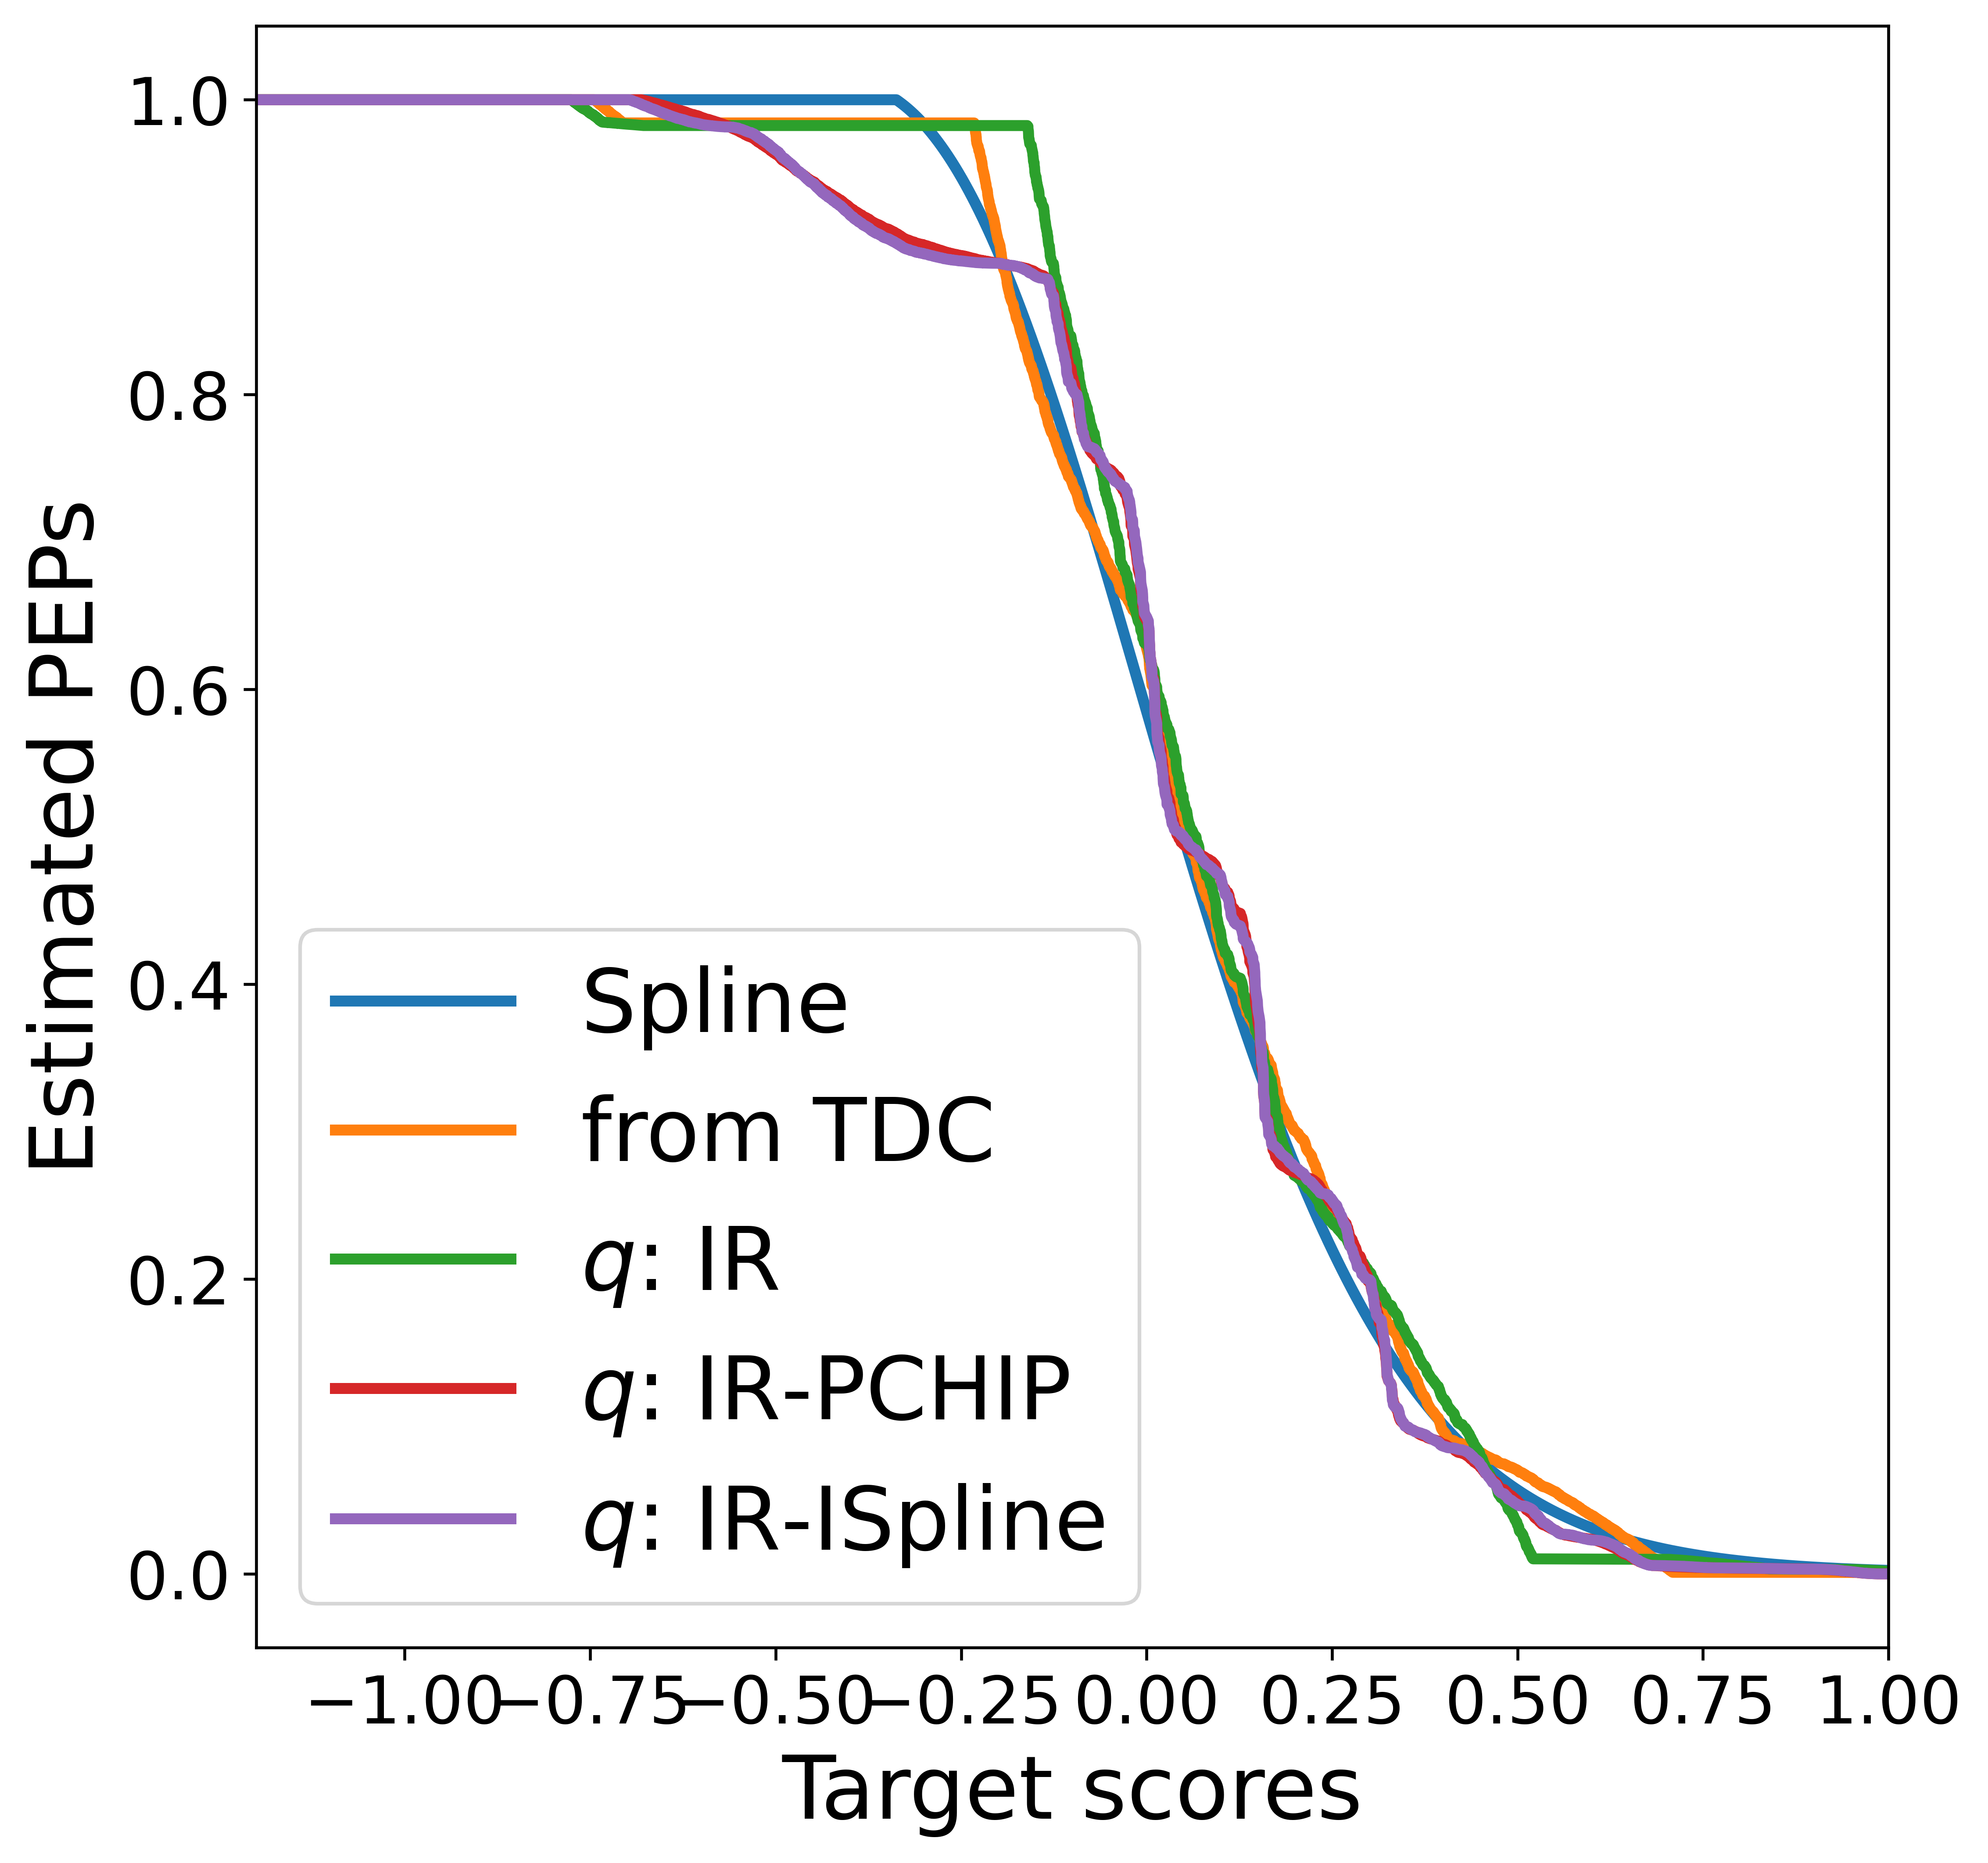

In [7]:
methods = ["spline", "obs2pep", "q2pep", "q2pep_pchip", "q2pep_ispline"]
df_cut = df[:]
plt.figure(figsize=(8, 8), dpi=600)
plt.figure(figsize=(8, 8), dpi=600)
score = df_cut["score"].values

for m in methods:
    plt.plot(score, df_cut[m], label=label_mapping[m]['label'], linewidth=3, linestyle=label_mapping[m]['linestyle'])

plt.xlabel("Target scores", fontsize=24)
plt.ylabel("Estimated PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(-1.2, 1)
plt.legend(loc="lower left", fontsize=24)
plt.show()

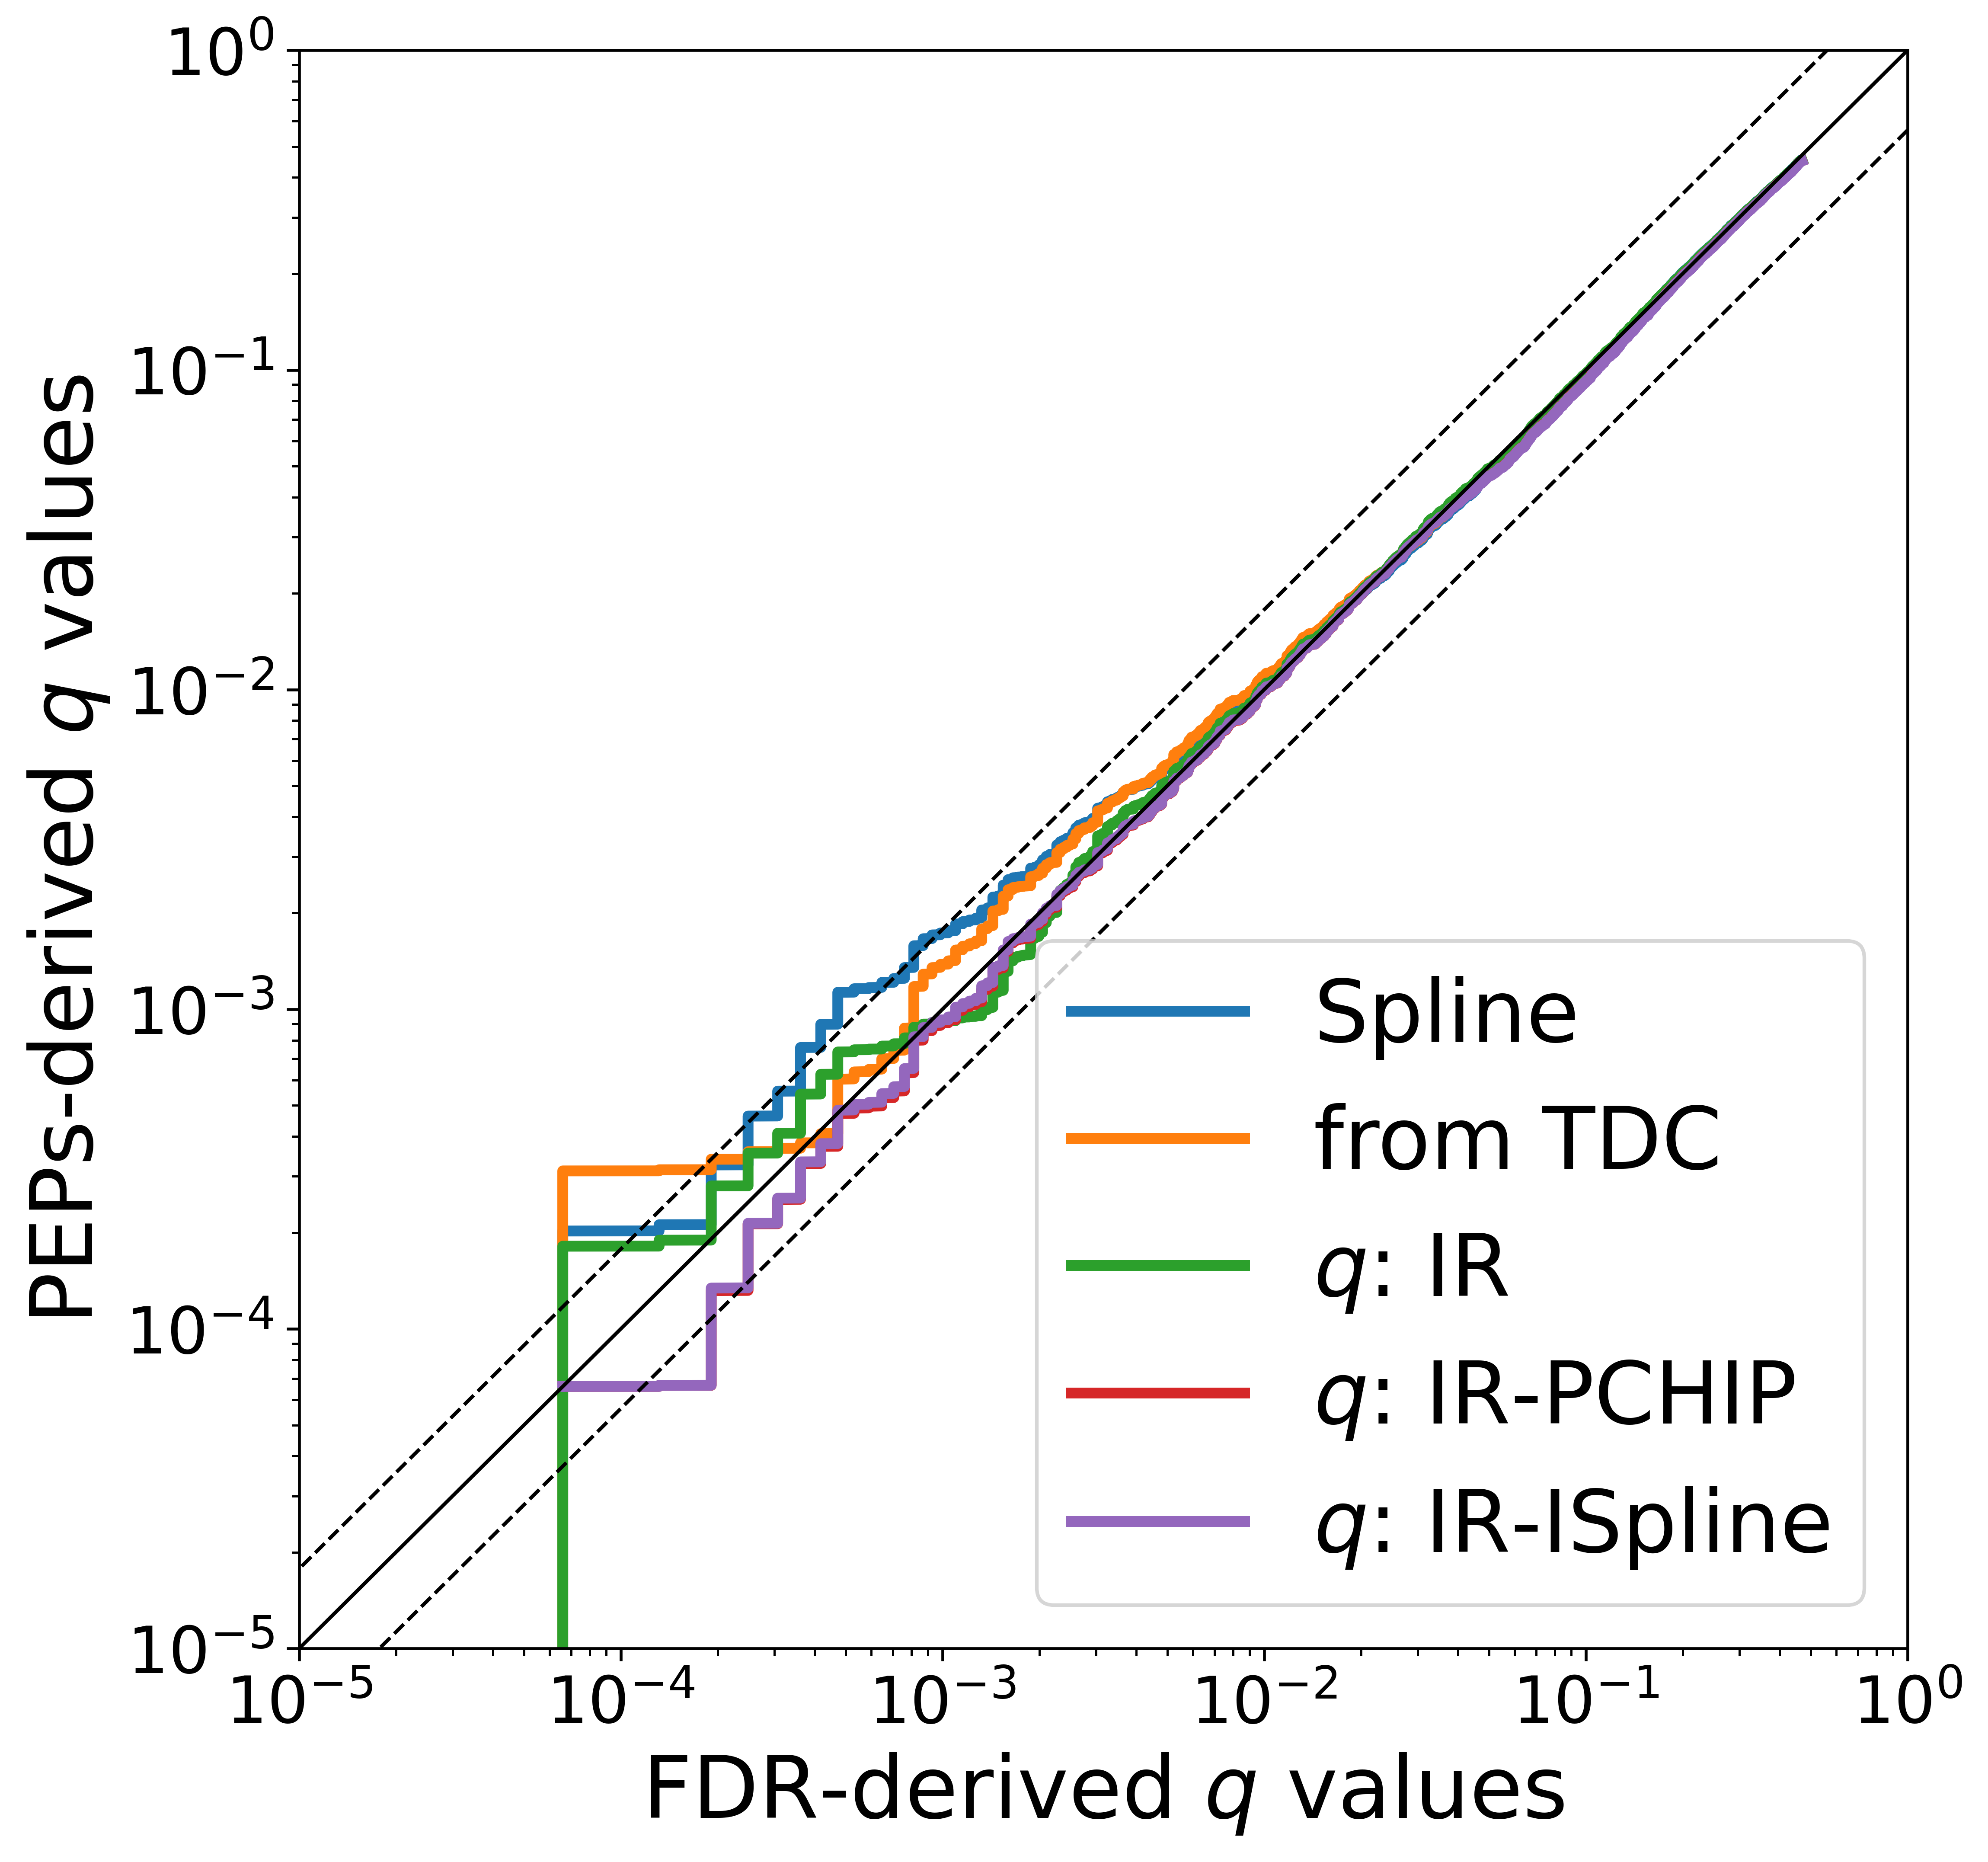

In [8]:
methods = ["spline", "obs2pep", "q2pep", "q2pep_pchip", "q2pep_ispline"]
plt.figure(figsize=(8, 8), dpi=600)
# plt.text(0.05, 0.9, "comment1", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
# plt.text(0.05, 0.85, "comment2", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
# plt.text(0.05, 0.8, "comment3", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
for m in methods:
    plt.plot(df["q-value"], df[f"q_{m}"], label=label_mapping[m]['label'], linestyle=label_mapping[m]['linestyle'], linewidth=3)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=1, linestyle="--")
plt.plot(a, c, c="k", linewidth=1, linestyle="--")
plt.plot(a, a, c="k", linewidth=1)
plt.xlabel("FDR-derived $q$ values", fontsize=24)
plt.ylabel("PEPs-derived $q$ values", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
# plt.savefig(f"figs/q-q.png",bbox_inches="tight")
plt.show()

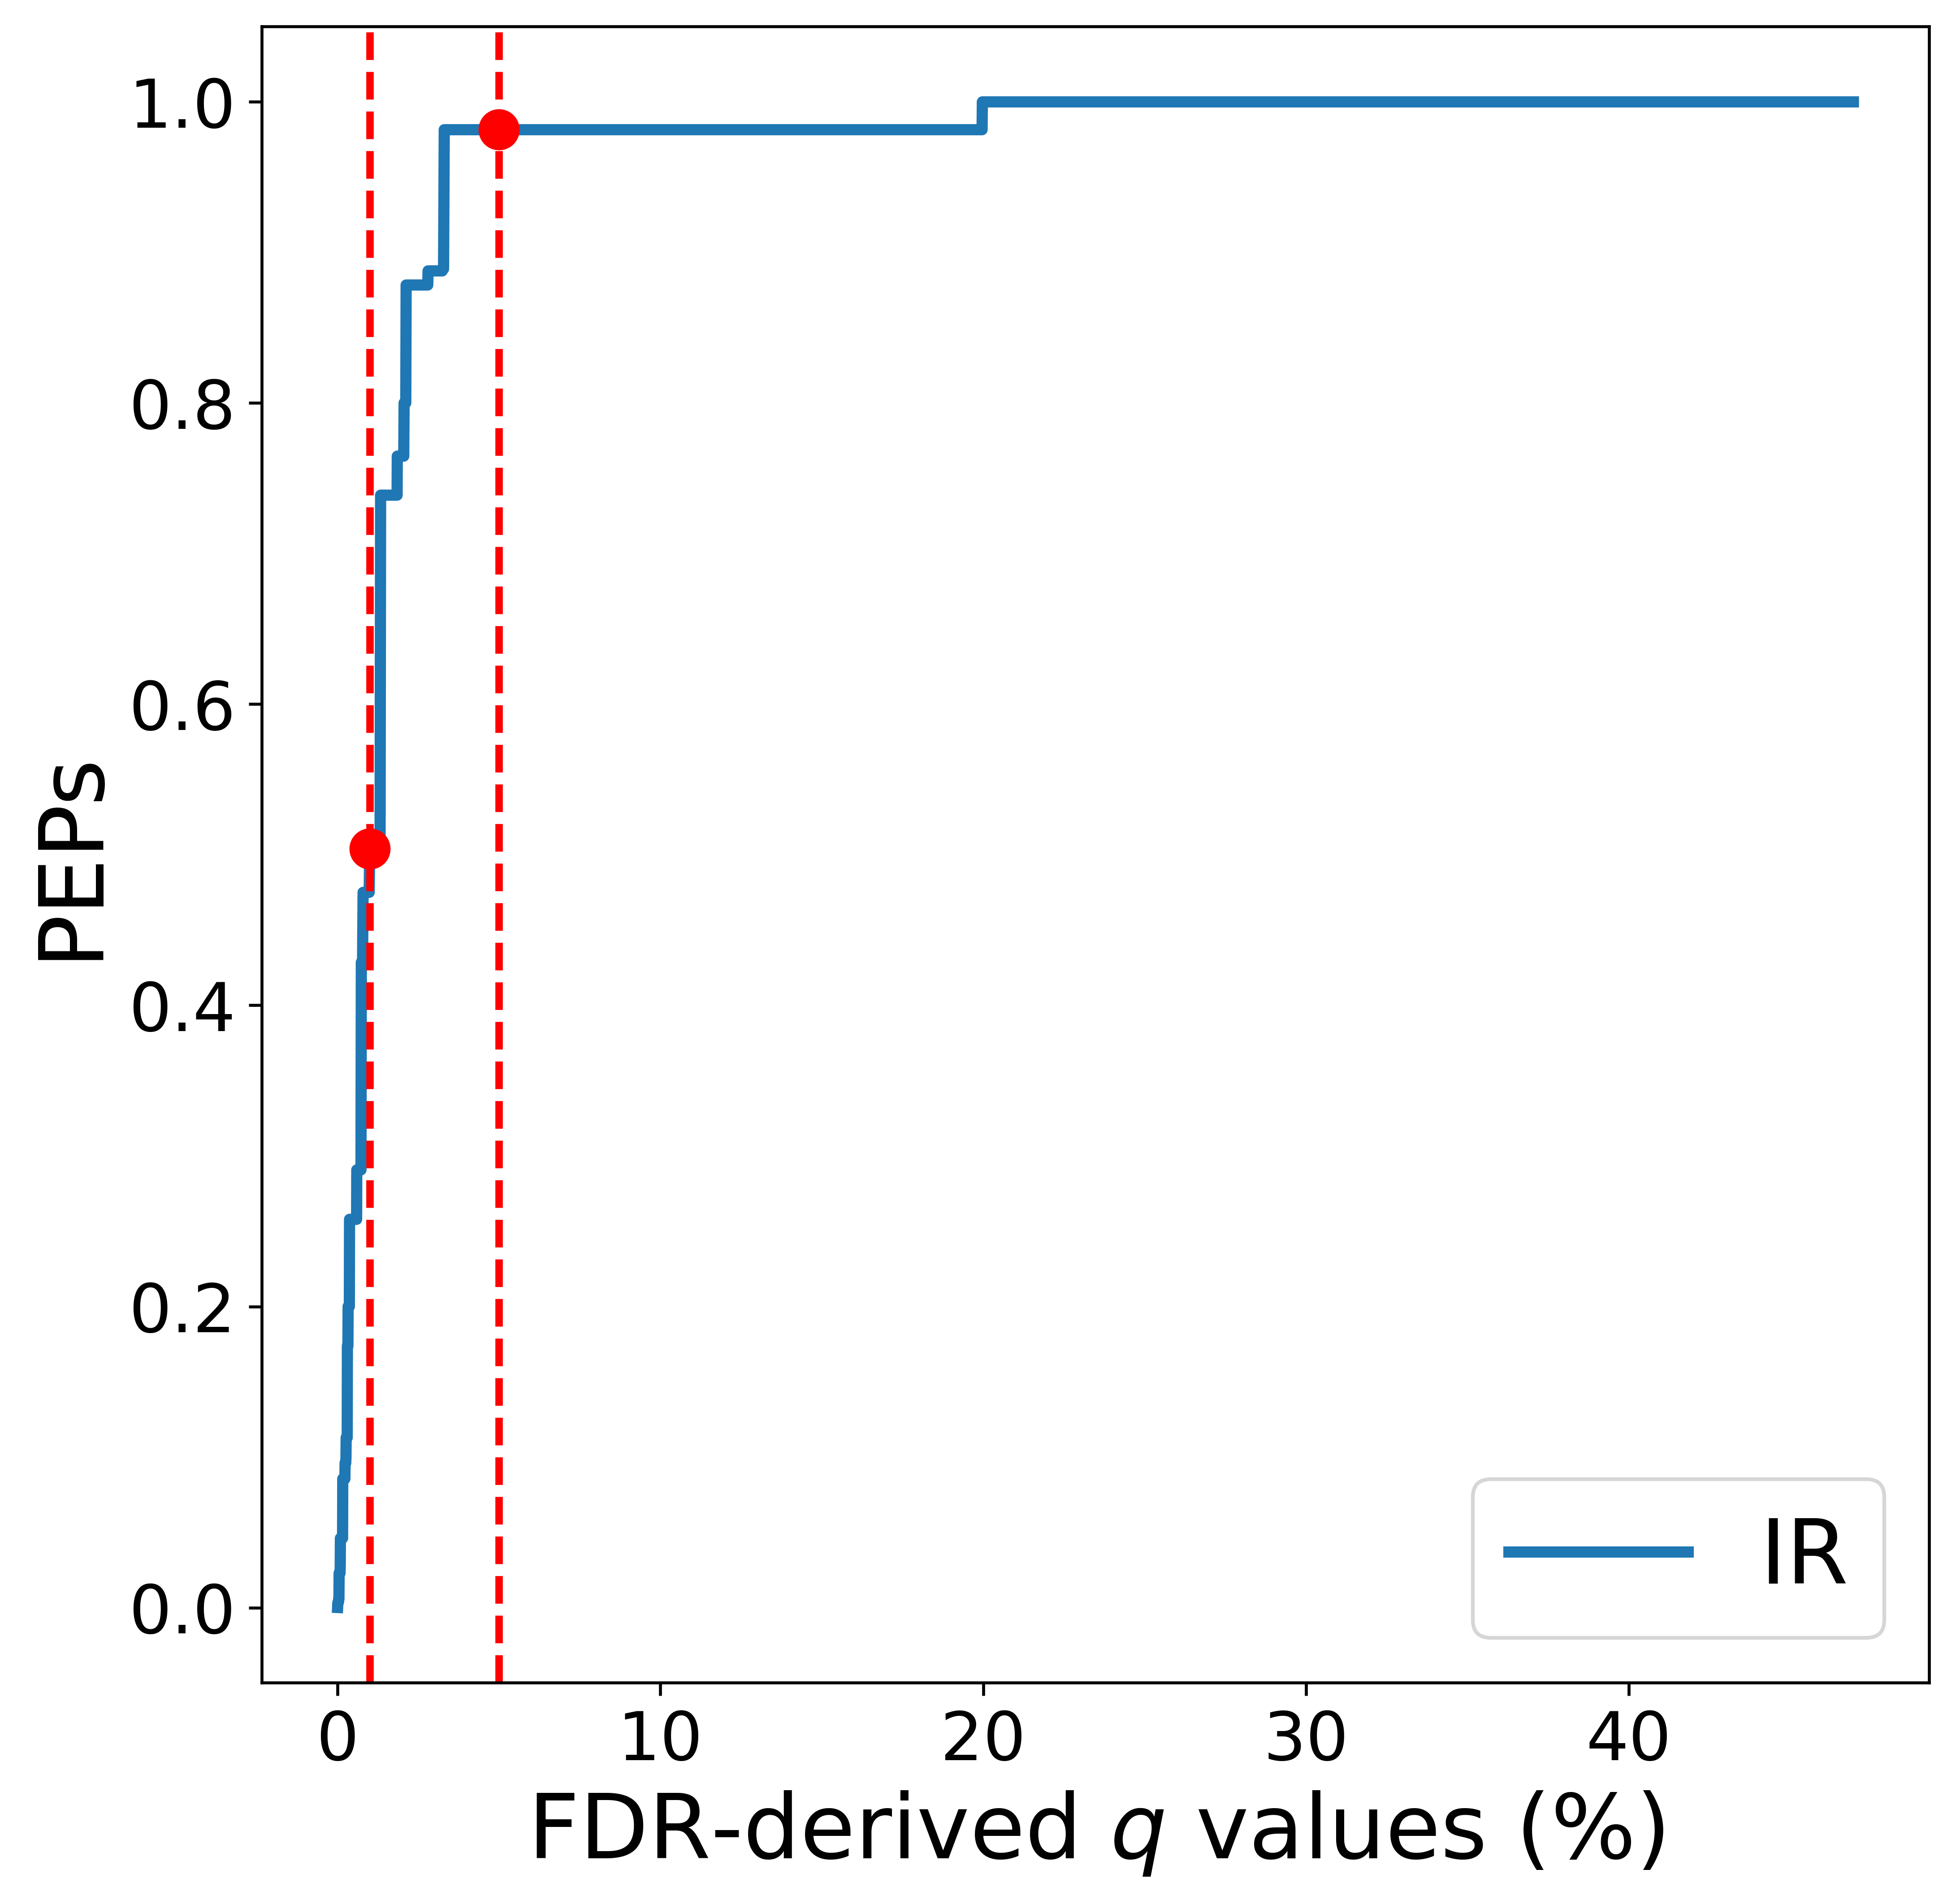

In [71]:
df_sub = df[df["q-value"] <= 1]
q_values = df_sub["q-value"] * 100
vertical_x = 1
pep_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep"]
# pep_spline = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "spline"]
# pep_ip_pava = df_sub.loc[(q_values - vertical_x).abs().idxmin(), "q2pep_ip"]

vertical_x5 = 5
pep_pava5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "q2pep"]
# pep_spline5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "spline"]
# pep_ip_pava5 = df_sub.loc[(q_values - vertical_x5).abs().idxmin(), "q2pep_ip"]

plt.figure(figsize=(8, 8), dpi=600)
plt.plot(q_values, df_sub["q2pep"], label='IR', linewidth=3, color='tab:blue')
# plt.plot(q_values, df_sub["spline"], label='Spline', linewidth=3, color='tab:orange')
# plt.plot(q_values, df_sub["q2pep_ip"], label='ip-PAVA', linewidth=3, color='tab:green')

plt.axvline(x=vertical_x, color='red', linestyle='--', linewidth=2)
plt.scatter([vertical_x], [pep_pava], color='red', s=100, zorder=3)
# plt.scatter([vertical_x], [pep_spline], color='red', s=100, zorder=3)
# plt.scatter([vertical_x], [pep_ip_pava], color='red', s=100, zorder=3)

# plt.text(vertical_x+0.5, pep_pava+0.03, f"PEP={pep_pava:.2f}", fontsize=24, color='tab:blue')
# plt.text(vertical_x+0.5, pep_spline-0.03, f"PEP={pep_spline:.2f}", fontsize=24, color='tab:orange')
# plt.text(vertical_x+0.5, pep_spline+0.09, f"PEP={pep_ip_pava:.2f}", fontsize=24, color='tab:green')

plt.axvline(x=vertical_x5, color='red', linestyle='--', linewidth=2)
plt.scatter([vertical_x5], [pep_pava5], color='red', s=100, zorder=3)
# plt.scatter([vertical_x5], [pep_spline5], color='red', s=100, zorder=3)
# plt.scatter([vertical_x5], [pep_ip_pava5], color='red', s=100, zorder=3)
# plt.text(vertical_x5-1.5, pep_spline5-0.12, f"PEP={pep_ip_pava5:.2f}", fontsize=24, color='red')

plt.xlabel("FDR-derived $q$ values (%)", fontsize=24)
plt.ylabel("PEPs", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=24)
plt.show()

In [75]:
df

score   q-value        spline   obs2pep  q_obs2pep     q2pep  \
0      6.82600  0.000192  2.419560e-16  0.000096   0.000096  0.000192   
1      6.70174  0.000192  4.550410e-16  0.000096   0.000096  0.000192   
2      6.40929  0.000192  2.012090e-15  0.000096   0.000096  0.000192   
3      6.35031  0.000192  2.715500e-15  0.000096   0.000096  0.000192   
4      6.30152  0.000192  3.479810e-15  0.000096   0.000096  0.000192   
...        ...       ...           ...       ...        ...       ...   
18987 -2.82819  0.528334  1.000000e+00  1.000000   0.524937  1.000000   
18988 -2.86435  0.528359  1.000000e+00  1.000000   0.524962  1.000000   
18989 -2.95645  0.528383  1.000000e+00  1.000000   0.524987  1.000000   
18990 -3.16205  0.528486  1.000000e+00  1.000000   0.525012  1.000000   
18991 -3.16400  0.528486  1.000000e+00  1.000000   0.525037  1.000000   

        q_q2pep  q2pep_ip  q_q2pep_ip  q2pep_smooth  q_q2pep_smooth  \
0      0.000192  0.000192    0.000192      0.000192        0.000192   
1      0.000192  0.000192    0.000192      0.000192        0.000192   
2      0.000192  0.000192    0.000192      0.000192        0.000192   
3      0.000192  0.000192    0.000192      0.000192        0.000192   
4      0.000192  0.000192    0.000192      0.000192        0.000192   
...         ...       ...         ...           ...             ...   
18987  0.524963  1.000000    0.526815      1.000000        0.524963   
18988  0.524988  1.000000    0.526840      1.000000        0.524988   
18989  0.525013  1.000000    0.526865      1.000000        0.525013   
18990  0.525038  1.000000    0.526890      1.000000        0.525038   
18991  0.525063  1.000000    0.526915      1.000000        0.525063   

       q2pep_ip_smooth  q_q2pep_ip_smooth      q_spline  
0             0.000192           0.000192  2.419560e-16  
1             0.000192           0.000192  3.484985e-16  
2             0.000192           0.000192  9.030290e-16  
3             0.000192           0.000192  1.356147e-15  
4             0.000192           0.000192  1.780879e-15  
...                ...                ...           ...  
18987         1.000000           0.527161  5.256638e-01  
18988         1.000000           0.527186  5.256888e-01  
18989         1.000000           0.527210  5.257138e-01  
18990         1.000000           0.527235  5.257387e-01  
18991         1.000000           0.527260  5.257637e-01  

[18992 rows x 14 columns]